In [10]:
import json
import math
from typing import List, Dict
import random
import os

def load_scenes(file_path: str) -> List[Dict]:
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data['scenes']

folder = '/Users/zechengli/Desktop/CLEVR_v1.0'

scenes = load_scenes(os.path.join(folder, 'scenes/CLEVR_train_scenes.json'))

In [81]:
def equidistant_question(scene: Dict) -> Dict:
    objects = scene['objects']
    if len(objects) < 4:
        return None
    
    obj1, obj2, obj3, obj4 = random.sample(objects, 4)
    
    question = f"If the {obj1['color']} {obj1['shape']} were moved to be equidistant from the {obj2['color']} {obj2['shape']} and the {obj3['color']} {obj3['shape']}, would it be closer to or farther from the {obj4['color']} {obj4['shape']}? Select the most appropriate answer (only returns one of the A, B, C, D):"
    
    # Calculate distances
    def distance(o1, o2):
        return math.sqrt(sum((a-b)**2 for a, b in zip(o1['3d_coords'], o2['3d_coords'])))
    
    mid_point = [(a+b)/2 for a, b in zip(obj2['3d_coords'], obj3['3d_coords'])]
    current_dist = distance(obj1, obj4)
    new_dist = math.sqrt(sum((a-b)**2 for a, b in zip(mid_point, obj4['3d_coords'])))
    
    option_texts = [
        "It would be closer to",
        "It would be farther from",
        "It would remain equidistant from",
        "It is impossible to determine"
    ]
    random.shuffle(option_texts)
    
    options = [
        ("A", option_texts[0]),
        ("B", option_texts[1]),
        ("C", option_texts[2]),
        ("D", option_texts[3])
    ]
    
    answer_text = "closer to" if new_dist < current_dist else "farther from"
    answer_letter = next(opt for opt, text in options if text.endswith(answer_text))
    
    formatted_options = "\n".join([f"{opt}: {text}" for opt, text in options])
    
    return {
        "question": f"{question}\n\n{formatted_options}",
        "answer": answer_letter,
        "options": [opt for opt, _ in options]
    }

In [82]:
import math

def rotate_point(x, y, cx, cy, angle):
    """Rotate a point around a center."""
    angle_rad = math.radians(angle)
    cos_angle = math.cos(angle_rad)
    sin_angle = math.sin(angle_rad)
    
    nx = cos_angle * (x - cx) - sin_angle * (y - cy) + cx
    ny = sin_angle * (x - cx) + cos_angle * (y - cy) + cy
    
    return nx, ny

def rotation_question(scene: Dict) -> Dict:
    objects = scene['objects']
    if len(objects) < 3:
        return None
    
    # Find the center of the image
    min_x = min(obj['pixel_coords'][0] for obj in objects)
    max_x = max(obj['pixel_coords'][0] for obj in objects)
    min_y = min(obj['pixel_coords'][1] for obj in objects)
    max_y = max(obj['pixel_coords'][1] for obj in objects)
    
    center_x = (min_x + max_x) / 2
    center_y = (min_y + max_y) / 2
    
    # Rotate objects and find the one closest to top-right corner
    rotated_objects = []
    for obj in objects:
        x, y = obj['pixel_coords'][0], obj['pixel_coords'][1]
        rx, ry = rotate_point(x, y, center_x, center_y, 90)
        distance_to_corner = math.sqrt((rx - max_x)**2 + (ry - min_y)**2)
        rotated_objects.append((obj, distance_to_corner))
    
    # print obj and distance_to_corner and sort by distance_to_corner
    # print([(obj['color'], obj['shape'], distance) for obj, distance in sorted(rotated_objects, key=lambda x: x[1])])
    
    closest_obj = min(rotated_objects, key=lambda x: x[1])[0]

    # Find the rightmost object
    rightmost_obj = max(objects, key=lambda obj: obj['pixel_coords'][0])

    # Find the top 2 and top 3 objects (excluding the closest and rightmost)
    top_objects = sorted(
        [obj for obj, _ in rotated_objects if obj != closest_obj and obj != rightmost_obj],
        key=lambda obj: obj['pixel_coords'][1]
    )[:2]

    if len(top_objects) < 2:
        return None
    
    question = f"If all objects were rotated 90 degrees clockwise around the center of the image, which object would then be closest to the top-right corner? Select the most appropriate answer (only returns one of the A, B, C, D):"
    answer = f"The {closest_obj['color']} {closest_obj['shape']}"
    
    # Generate options
    object_options = [
        closest_obj,
        rightmost_obj,
        top_objects[0],
        top_objects[1]
    ]
    random.shuffle(object_options)
    
    options = [
        ("A", f"The {object_options[0]['color']} {object_options[0]['shape']}"),
        ("B", f"The {object_options[1]['color']} {object_options[1]['shape']}"),
        ("C", f"The {object_options[2]['color']} {object_options[2]['shape']}"),
        ("D", f"The {object_options[3]['color']} {object_options[3]['shape']}")
    ]
    
    answer_letter = next(opt for opt, obj in zip("ABCD", object_options) if obj == closest_obj)
    
    formatted_options = "\n".join([f"{opt}: {text}" for opt, text in options])
    
    return {
        "question": f"{question}\n\n{formatted_options}",
        "answer": answer_letter,
        "options": [opt for opt, _ in options]
    }

Question: If the cyan cube were moved to be equidistant from the brown cylinder and the green cylinder, would it be closer to or farther from the gray cube? Select the most appropriate answer (only returns one of the A, B, C, D):

A: It would be farther from
B: It would be closer to
C: It is impossible to determine
D: It would remain equidistant from
Answer: B
Image: CLEVR_train_000000.png


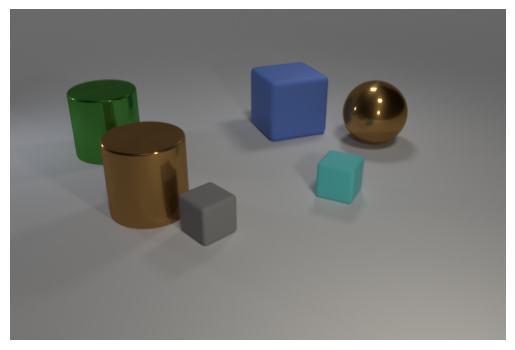


Question: If all objects were rotated 90 degrees clockwise around the center of the image, which object would then be closest to the top-right corner? Select the most appropriate answer (only returns one of the A, B, C, D):

A: The green cylinder
B: The blue cube
C: The brown sphere
D: The brown cylinder
Answer: A
Image: CLEVR_train_000000.png


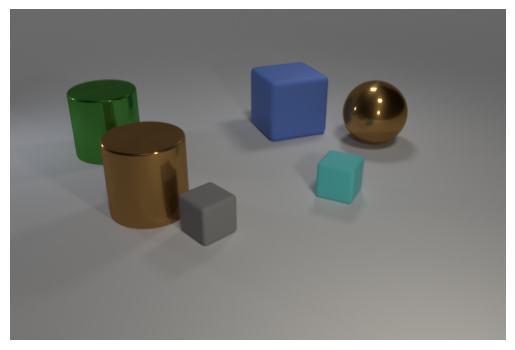

In [86]:
import matplotlib.pyplot as plt
from PIL import Image

def generate_questions(scenes: List[Dict], num_questions: int) -> List[Dict]:
    questions = []
    question_generators = [equidistant_question, rotation_question]  # Add all your question generators here
    scene_index = 0
    
    while len(questions) < num_questions * len(question_generators):
        scene = scenes[scene_index]
        
        for generator in question_generators:
            question = generator(scene)
            if question:
                question['image_filename'] = scene['image_filename']
                questions.append(question)
        
        # Move to the next scene
        scene_index = (scene_index + 1) % len(scenes)
    
    return questions

generated_questions = generate_questions(scenes, 1)
for q in generated_questions:
    print(f"Question: {q['question']}")
    print(f"Answer: {q['answer']}")
    print(f"Image: {q['image_filename']}")
    
    # Load and display the image
    img_path = os.path.join(folder, 'images', 'train', q['image_filename'])
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print()

In [93]:
import matplotlib.pyplot as plt
from PIL import Image
import shutil

def generate_questions(scenes: List[Dict], num_questions: int) -> List[Dict]:
    questions = []
    question_generators = [equidistant_question, rotation_question]
    scene_index = 0
    question_id = 0
    
    while len(questions) < num_questions * len(question_generators):
        scene = scenes[scene_index]
        
        for generator in question_generators:
            question = generator(scene)
            if question:
                image_filename = scene['image_filename']
                new_image_path = os.path.join('CLEVR', image_filename)
                
                questions.append({
                    'id': question_id,
                    'category': 'spatial_reasoning',
                    'image_path': new_image_path,
                    'question': question['question'],
                    'answer': question['answer']
                })
                question_id += 1
                
                # Copy image to new folder
                old_path = os.path.join('/Users/zechengli/Desktop/CLEVR_v1.0', 'images', 'train', image_filename)
                new_path = os.path.join('/Users/zechengli/Desktop/CLEVR', image_filename)
                os.makedirs(os.path.dirname(new_path), exist_ok=True)
                shutil.copy2(old_path, new_path)
        
        scene_index = (scene_index + 1) % len(scenes)
    
    return questions

generated_questions = generate_questions(scenes, 50)
# dump to json
with open('CLEVR_spatial_reasoning.json', 'w') as f:
    json.dump(generated_questions, f)
# for q in generated_questions:
#     print(f"ID: {q['id']}")
#     print(f"Category: {q['category']}")
#     print(f"Image Path: {q['image_path']}")
#     print(f"Question: {q['question']}")
#     print(f"Answer: {q['answer']}")
    
#     # Load and display the image
#     img_path = os.path.join('/Users/zechengli/Desktop/CLEVR', os.path.basename(q['image_path']))
#     img = Image.open(img_path)
#     plt.imshow(img)
#     plt.axis('off')
#     plt.show()
#     print()